In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants, optimize, signal
from pyproj import Geod
from scipy.optimize import minimize
import os
import glob

In [227]:
def filter_t_series(t, samples, sos, thresh=np.timedelta64(20000, "ns")):
    """
    Filters time series accounting for discontinuities

    Parameters
    ----------
    t : np.array of np.datetime64
        time array
    samples : np.array of float
        samples
    sos : filter object
        sso filter object
    thresh : np.timedelta64, optional
        The minimal time gap needed for a discontinuity.
        The default is np.timedelta64(20000, "ns").

    Returns
    -------
    np.array float
        filtered array.

    """
    if len(t) > 0:
        dt = np.diff(t)
        new_samples = []
        current_idx = 0
        l1 = np.where(dt > thresh)[0]
        l1 = np.hstack((l1, len(samples) - 1))
        l1 += 1
    
        for end_idx in l1:
            new_sample_tmp = signal.sosfilt(sos,
                                            samples[current_idx:end_idx])
    
            current_idx = end_idx
    
            new_samples += list(new_sample_tmp)
    
        return new_samples
    else:
        return []


def atddict(long, lat, ref):
    '''
   Finds the Arrival Time Difference between a reference node and each other node
    based on an inputted longitude and latitude of a meteorite. Returns a dictionary
    with Site as key and ATD as value.
    '''
    
    #start atd dictionary
    atd = {}
    
    #define the speed of light in m/s (can change if we find it is different)
    c = 299792458
    
    # Loop between each node in node_config
    for node in node_config:
        geod = Geod(ellps='WGS84')
        
        # Use the geod function to find the dist to the for the node
        _, _, dist = geod.inv(node_config[node]['Position']['lon'], node_config[node]['Position']['lat'], long, lat)

        # Use the geod function to find the dist to the reference node
        _, _, ref_dist = geod.inv(node_config[ref]['Position']['lon'], node_config[ref]['Position']['lat'], long, lat)

        # Calculate the time difference
        timediff = (dist / c) - (ref_dist / c)

        # Add the ATD to the ATD dictionary in ns
        atd[node_config[node]['Site']] = np.timedelta64(int(timediff * 1e9),'ns')
        
    return atd

# Load the node config dictionary this contains information about the nodes
# (receivers) position and name
prog_start = np.datetime64("now")
node_config = np.load("node_config_fixed.npy", allow_pickle=True).item()
node_code = {}
datadict = {key: {"time": [],
                  "waveform": []} for key in node_config}
# LEELA sampling dt
dt = np.timedelta64(int(1e9 / 109375), "ns")
t = np.arange(0, 1024, 1) * dt

# Set parameter atds to be a dictionary with Watnall as the reference node
atds = atddict(-2.29,53.28,'569218Q0B001D0029')
window_dt = np.timedelta64(120000, "ms")
start_time = np.datetime64("2023-02-13T02:59:00")
end_time = np.datetime64("2023-02-13T03:01:00")

# Create filter here so only processed once:
lower_f = 2000
upper_f = 10000
sos = signal.butter(6, [lower_f,upper_f], 'bp', fs=1/9142e-9, output='sos')

for key in node_config.keys():

    # File path to data files (if have hard drive then: /Volumes/WD_ITP/Bath_VLF_2023_decoded)
    folder_path = '/Users/tjr2099/Library/CloudStorage/OneDrive-UniversityofBath/Physics w Astro Year 4/Industry Team Project/Arrival Time Difference Practice/fireball_data/Bath_VLF_2023_decoded/2023-02-13/'
    # Create list of file paths for each file in the folder
    file_list = glob.glob(folder_path + "*" + key + '*20230213*.npy')

    # Code to create a list of all the data for each of the files
    for file_path in file_list:
        #print("Reading: " + file_path)
        chunks = np.load(file_path, allow_pickle=True).item()
        for chunk in chunks:
            datadict[key]["time"].append(chunks[chunk]["starttime"])
            datadict[key]["waveform"].append(chunks[chunk]["wvfmdata"])

print("data loaded")


data loaded


In [ ]:
datadict['569218Q0B001D0029']["time"] = np.array(datadict['569218Q0B001D0029']["time"],
                                              dtype=np.datetime64)
l1 = np.where((datadict['569218Q0B001D0029']["time"] >= start_time) &
                          (datadict['569218Q0B001D0029']["time"] <= end_time))[0]
samples = np.array([])
time = np.array([], dtype=np.datetime64)

lower_f = 3000
upper_f = 10000
sos = signal.butter(10, [lower_f,upper_f], 'bp', fs=1/9142e-9, output='sos')

for i in l1:
    samples = np.hstack((samples, datadict['569218Q0B001D0029']["waveform"][i]))
    time = np.hstack((time, datadict['569218Q0B001D0029']["time"][i] + t))

    filtered_samples = np.array(filter_t_series(time,samples,sos))

In [ ]:
print(time.min())
print(time.max())

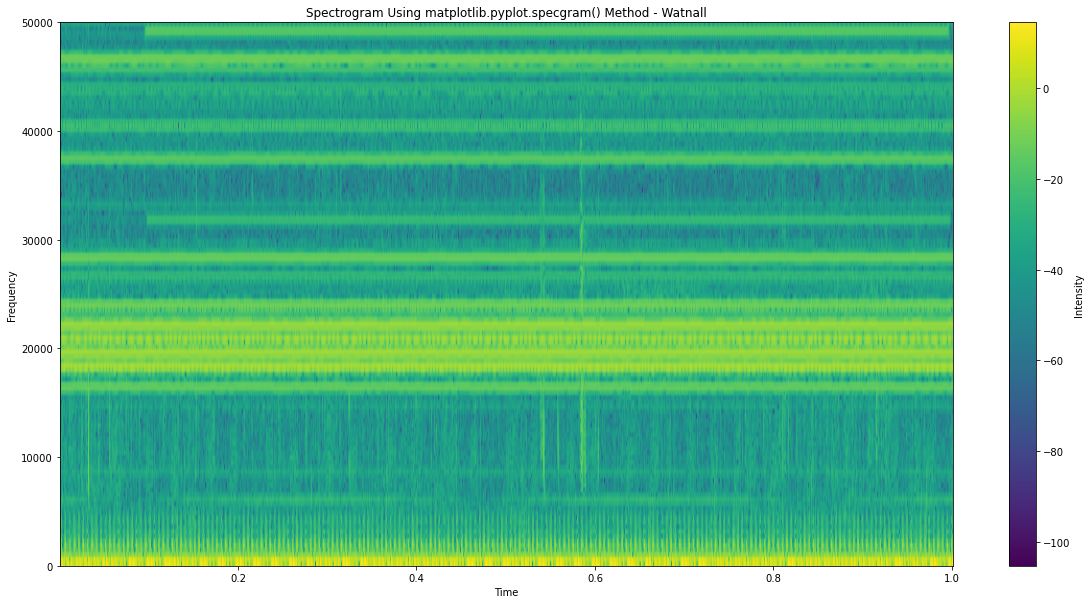

In [235]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import savgol_filter

#smoothed_samples = savgol_filter(filtered_samples,window_length=15,polyorder=2)
 
# Matplotlib.pyplot.specgram() function to
# generate spectrogram
fig,ax = plt.subplots(figsize=(20,10))
spec = ax.specgram(samples, Fs=1/9.142e-6)#,vmin=-100, vmax=0)

 
# Set the title of the plot, xlabel and ylabel
# and display using show() function
plt.title('Spectrogram Using matplotlib.pyplot.specgram() Method - ' + str(node_config['569218Q0B001D0029']['Site']))
cbar = fig.colorbar(spec[3], ax=ax)

# Set colorbar label
cbar.set_label('Intensity')
ax.set_xlabel('Time')
ax.set_ylabel("Frequency")
ax.set_ylim(0,50000)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (109568,) and (109562,)

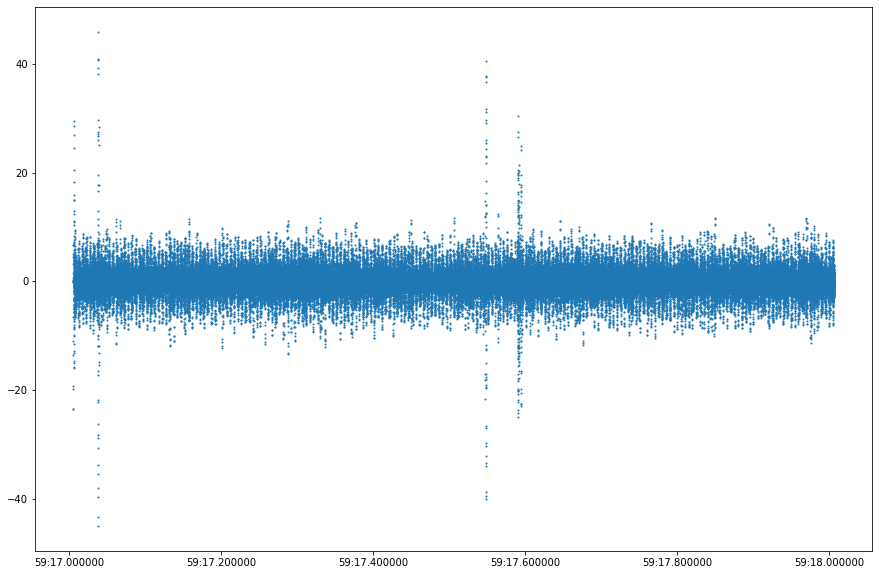

In [222]:
#smoothed_samples = savgol_filter(filtered_samples,window_length=13,polyorder=2)
def moving_average(data, window_size):
    # Apply the moving average and adjust indices
    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    start_index = (window_size - 1) // 2
    end_index = len(data) - start_index
    return smoothed_data[start_index:end_index]

# Example usage:
smoothed_samples = moving_average(filtered_samples, window_size=5)

fig, ax = plt.subplots(1,figsize=(15,10))
ax.scatter(time,filtered_samples,s=1)
ax.plot(time,smoothed_samples,c='r')

plt.show()

In [195]:
np.mean(filtered_samples)

1.9025384200596513e-05

ValueError: minvalue must be positive

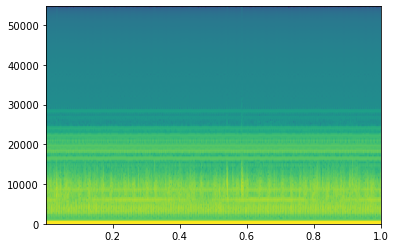

In [151]:
filtered_samples += 1e-100

plt.specgram(filtered_samples,Fs=1/9.142e-6)

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=LogNorm(), cmap=None),ax=ax)

plt.xlabel('Time')
plt.ylabel("Frequency")
plt.ylim(2000,10000)

plt.show()